In [3]:
# ✅ STEP 0: SETUP KAGGLE API & DOWNLOAD DATASET
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

import os
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded['kaggle.json'])
os.chmod('/root/.kaggle/kaggle.json', 600)

!kaggle datasets download -d jangedoo/utkface-new
!unzip -q utkface-new.zip -d /content/utkface

# ✅ STEP 1: IMPORT LIBRARIES
import torch, random, os, re
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import copy

# ✅ STEP 2: SEED FOR REPRODUCIBILITY
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ✅ STEP 3: DATASET CLASS
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.age_bins = [0, 18, 40, 60, 116]  # 4 classes
        self.samples = []

        for file in os.listdir(root_dir):
            if file.endswith('.jpg'):
                try:
                    age, gender, *_ = re.split(r'[_\.]', file)
                    age = int(age)
                    gender = int(gender)
                    age_label = self.bin_age(age)
                    self.samples.append((file, gender, age_label))
                except:
                    continue

    def bin_age(self, age):
        for i in range(len(self.age_bins) - 1):
            if self.age_bins[i] <= age < self.age_bins[i + 1]:
                return i
        return len(self.age_bins) - 2

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file, gender, age = self.samples[idx]
        path = os.path.join(self.root_dir, file)
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, gender, age

# ✅ STEP 4: TRANSFORM & DATA SPLIT
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

all_files = os.listdir("/content/utkface/UTKFace")
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

with open("train_list.txt", "w") as f:
    for item in train_files:
        f.write(f"{item}\n")
with open("val_list.txt", "w") as f:
    for item in val_files:
        f.write(f"{item}\n")

class SubsetDataset(UTKFaceDataset):
    def __init__(self, root, filelist, transform=None):
        super().__init__(root, transform)
        with open(filelist, 'r') as f:
            keep = set(line.strip() for line in f)
        self.samples = [s for s in self.samples if s[0] in keep]

train_data = SubsetDataset("/content/utkface/UTKFace", "train_list.txt", transform)
val_data = SubsetDataset("/content/utkface/UTKFace", "val_list.txt", transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# ✅ STEP 5: MODEL USING MobileNetV2
base_model = models.mobilenet_v2(pretrained=True)
for param in base_model.features.parameters():
    param.requires_grad = False  # freeze initially

class AgeGenderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.age_head = nn.Linear(256, 4)
        self.gender_head = nn.Linear(256, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x)
        return self.age_head(x), self.gender_head(x)

# ✅ STEP 6: TRAINING WITH EARLY STOPPING
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeGenderModel().to(device)

criterion_age = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_gender = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

best_loss = float('inf')
patience = 5
early_stop_counter = 0
best_weights = copy.deepcopy(model.state_dict())

for epoch in range(1, 61):
    model.train()
    running_loss = 0.0
    for images, genders, ages in train_loader:
        images, genders, ages = images.to(device), genders.to(device), ages.to(device)
        age_pred, gender_pred = model(images)
        loss = criterion_age(age_pred, ages) + criterion_gender(gender_pred, genders)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step(running_loss)
    print(f"Epoch {epoch:02d} | Loss: {running_loss:.4f}")

    if running_loss < best_loss:
        best_loss = running_loss
        best_weights = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping.")
            break

model.load_state_dict(best_weights)

# ✅ STEP 7: EVALUATION
def evaluate(model, loader):
    model.eval()
    y_true_a, y_pred_a = [], []
    y_true_g, y_pred_g = [], []
    with torch.no_grad():
        for imgs, genders, ages in loader:
            imgs = imgs.to(device)
            out_age, out_gender = model(imgs)
            y_true_a.extend(ages.numpy())
            y_pred_a.extend(out_age.argmax(1).cpu().numpy())
            y_true_g.extend(genders.numpy())
            y_pred_g.extend(out_gender.argmax(1).cpu().numpy())

    age_acc = accuracy_score(y_true_a, y_pred_a)
    gender_acc = accuracy_score(y_true_g, y_pred_g)
    overall_acc = np.mean((np.array(y_true_a) == np.array(y_pred_a)) &
                          (np.array(y_true_g) == np.array(y_pred_g)))
    return age_acc, gender_acc, overall_acc

a, g, o = evaluate(model, val_loader)
print(f"\n✅ Age Accuracy: {a*100:.2f}%")
print(f"✅ Gender Accuracy: {g*100:.2f}%")
print(f"✅ Overall Accuracy: {o*100:.2f}%")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 90% 298M/331M [00:03<00:00, 63.9MB/s]
100% 331M/331M [00:03<00:00, 97.7MB/s]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 64.3MB/s]


Epoch 01 | Loss: 918.3298
Epoch 02 | Loss: 847.2847
Epoch 03 | Loss: 828.9987
Epoch 04 | Loss: 816.5709
Epoch 05 | Loss: 814.2967
Epoch 06 | Loss: 805.9971
Epoch 07 | Loss: 800.0741
Epoch 08 | Loss: 797.2722
Epoch 09 | Loss: 790.5527
Epoch 10 | Loss: 792.2697
Epoch 11 | Loss: 785.3386
Epoch 12 | Loss: 785.2907
Epoch 13 | Loss: 780.9602
Epoch 14 | Loss: 779.7868
Epoch 15 | Loss: 773.2843
Epoch 16 | Loss: 770.8909
Epoch 17 | Loss: 768.9095
Epoch 18 | Loss: 766.1411
Epoch 19 | Loss: 766.9568
Epoch 20 | Loss: 763.6504
Epoch 21 | Loss: 762.4249
Epoch 22 | Loss: 757.7749
Epoch 23 | Loss: 757.3136
Epoch 24 | Loss: 756.2541
Epoch 25 | Loss: 754.0767
Epoch 26 | Loss: 754.9890
Epoch 27 | Loss: 749.7865
Epoch 28 | Loss: 749.8992
Epoch 29 | Loss: 747.9661
Epoch 30 | Loss: 746.6948
Epoch 31 | Loss: 744.8172
Epoch 32 | Loss: 744.0847
Epoch 33 | Loss: 743.2062
Epoch 34 | Loss: 738.5568
Epoch 35 | Loss: 738.4731
Epoch 36 | Loss: 733.7852
Epoch 37 | Loss: 735.3575
Epoch 38 | Loss: 732.7302
Epoch 39 | L

In [9]:
torch.save(best_weights, 'best_model.pt')

In [10]:
# ✅ Import Libraries
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn

# ✅ Age and Gender Labels
age_labels = ['0-17', '18-39', '40-59', '60+']
gender_labels = ['Male', 'Female']

# ✅ Define Your Model Class (Same as Training)
class AgeGenderModel(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.mobilenet_v2(pretrained=True)
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.age_head = nn.Linear(256, 4)
        self.gender_head = nn.Linear(256, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x)
        return self.age_head(x), self.gender_head(x)

# ✅ Load Trained Weights
model = AgeGenderModel()
model.load_state_dict(torch.load('best_model.pt', map_location='cpu'))
model.eval()

# ✅ Define Transform (Same as Training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Prediction Function
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        age_out, gender_out = model(img_tensor)
        age_pred = torch.argmax(age_out, dim=1).item()
        gender_pred = torch.argmax(gender_out, dim=1).item()

    # Display
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Age: {age_labels[age_pred]} | Gender: {gender_labels[gender_pred]}")
    plt.show()

# ✅ Run Prediction
#predict_image("women.jpg")  # Replace with your image file name





In [11]:
import torch
import pickle

# --- Recommended: Save state_dict ---
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model weights saved as best_model.pth")

# --- Optional: Save entire model with pickle ---
with open("best_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("✅ Entire model also saved as best_model.pkl")

# --- Optional: Download to your system ---
from google.colab import files
files.download("best_model.pth")
files.download("best_model.pkl")


✅ Model weights saved as best_model.pth
✅ Entire model also saved as best_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

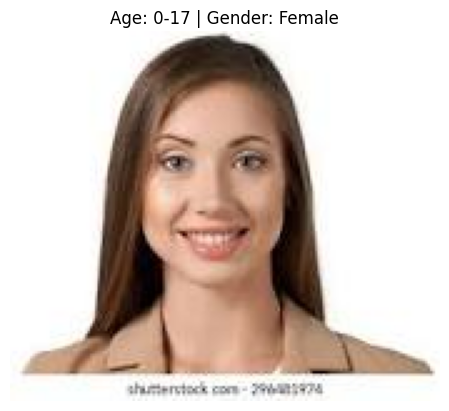

In [14]:
predict_image("img.jpg")

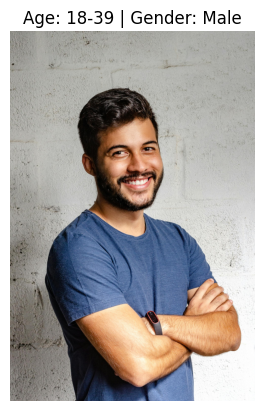

In [13]:
predict_image("male.jpg")

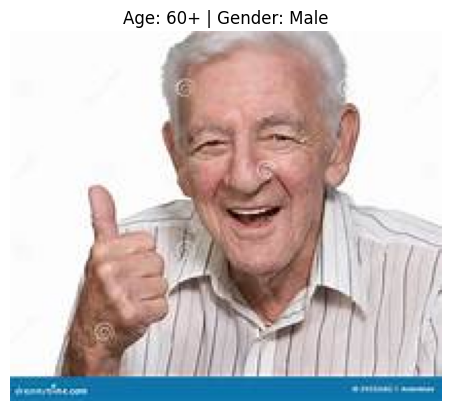

In [15]:
predict_image("OIP.jpg")